# Star Trail Image Stacker

### Using an Edge Detection Convolution Kernel

To counteract the problem described in [README.md](./README.md), the same Lighten blending can be applied only to selected pixels of a layer that contain a "star". To do that, we can perform edge-detection in the picture using a convolution kernel. This selects the stars, which appear as lines/dots with clear contrast, but not clouds which have soft edges. The result is then used as a mask to lighten-blend the image in sequence with its previous one.

-------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob, os

# import ipywidgets as widgets
from tqdm.notebook import tqdm # progressbar
import IPython.display as disp

# list available backends
# 'widget' backend allows interactive plots within the notebook
# Matplotlib is convenient for zooming into the image and viewing pixel coordinates/values
%matplotlib -l      
%matplotlib inline 
# 'inline' is not interactive like 'widget' but images get saved to the notebook file; viewable without running the code


Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


#### 1. Select Images

- Specify the paths to input images as a list in `SOURCE_PATH`. If it is a serially numbered image sequence, wildcards such as `*`, `[]`, etc can be used with `glob` to generate the list automatically.
- `BASE_PATH` contains the path of a single image which will form the bottom-most layer of the image stack. All the other source images are blended together above this, and only the stars from them will appear above it, while the rest of the background will be the same as that of this image.


In [2]:
print("Current Working Directory :", os.getcwd())

SOURCE_PATH = glob.glob("./data/JPEG/*.jpg")
BASE_PATH   = "./data/JPEG/4J7A6511.jpg"


SOURCE_PATH.sort()

if not SOURCE_PATH:
    raise FileNotFoundError("Please set a valid image sequence path for SOURCE_PATH")
if not os.path.isfile(BASE_PATH):
    raise FileNotFoundError("Please set a valid image path for BASE_PATH")


_abs_source = list(map(os.path.abspath, SOURCE_PATH))
if os.path.abspath(BASE_PATH) in _abs_source:
    SOURCE_PATH.pop(_abs_source.index(os.path.abspath(BASE_PATH)))

Current Working Directory : /Users/gautamd/Home/github/startrail-merger


In [3]:
def displayimg(img, title=None, figsize=(12, 8), close=None):
    """Use matplotlib to display an image"""
    
    fax = fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title :
        ax.set_title(title)
    fig.subplots_adjust(bottom=0, top=1, left=0.1, right=0.9)
    if isinstance(close, plt.Figure) :
        plt.close(close)
    return fax


#### 2. Slice

To reduce the time taken to re-process the entire image everytime any parameters are tweaked, you can choose to just process a sub-section of the image.
Specify

```SLICE = (x1, y1, x2, y2)``` 

in the code cell below to identify the top-left (x1, y1) and bottom-right (x2, y2) of the rectangular region to process.
- Use `SLICE = (0, 0, *baseImg.shape[:2])` to select the entire Image

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Base Image'}>)

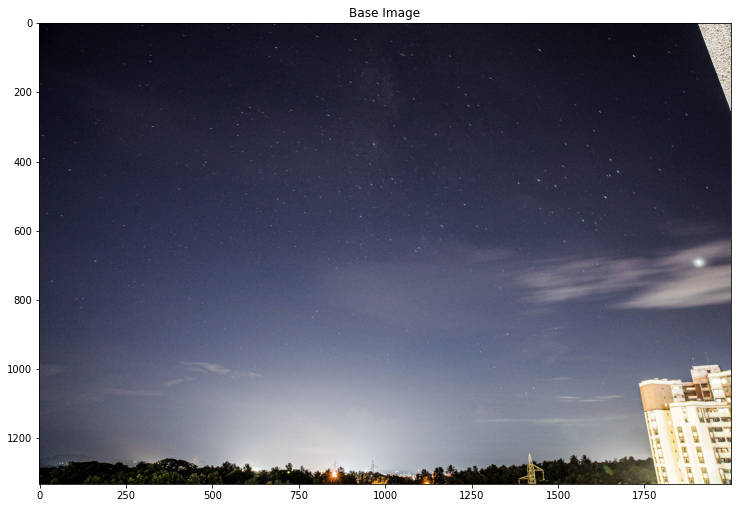

In [4]:
baseImg = cv2.imread(BASE_PATH)

SLICE = (0, 0, *baseImg.shape[:2])
# SLICE = (2000, 500, 3500, 1500)

assert SLICE[2] > SLICE[0] >= 0 and SLICE[3] > SLICE[1] >= 0, "Invalid bounding box"

displayimg(baseImg[SLICE[1]:SLICE[2], SLICE[0]:SLICE[3]], "Base Image")

In [5]:
outline_kernel = np.array([[-1, -1, -1],
                           [-1, 8, -1],
                           [-1, -1, -1]])

dil_kernel = np.ones((3, 3), np.uint8)

#### 3. Blending

The following cell contains the code to blend the images. There are 4 adjustable parameters for creating the masks :
- `edge_tol` : A scalar factor that will be multiplied with the convolution kernel for outline selection (effectively just brightens/dims the image a bit).
- `blur_size` : Kernel size for smoothing the image after edge detection, reduces noise. Most effective is < 10 pixels.
- `dil_iter` : Number of dilation iterations to the smoothed edge mask, to marginally increase width of the selected area. Increases processing time.
- `thresh` : Threshold grayscale value for creating a binary mask from the image (how much to finally select).

Checking '_Save_' will also save each image to the location `./processed/{filename}` where `.` is the current directory. If such an image already exists, it will fail unless '_Overwrite_' is also checked.

### Selective Blending Result

  0%|          | 0/31 [00:00<?, ?it/s]

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Result using the Mask generated by convolution'}>)

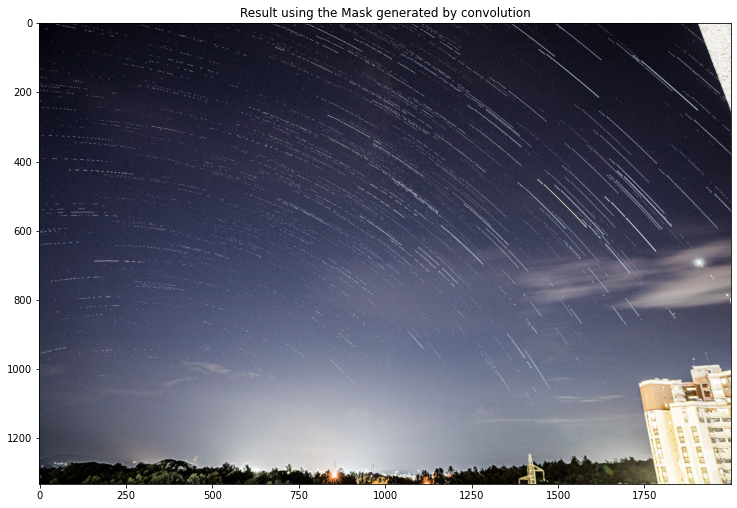

In [6]:

disp.display(disp.Markdown("### Selective Blending Result"))

"""
Change the arguments in the function below :

- EDGE_TOL  : `int` from 1..14
- BLUR_SIZE : odd `int` from 3,5,7,9,11... 
- DIL_ITER  : `int` >= 1
- THRESH    : `int` from 0..255

- SAVE      : `bool`
- OVERWRITE : `bool`
"""

imgView = None

# @widgets.interact_manual(edge_tol=(1,14), blur_size=(3,13,2), dil_iter=(1,5), thresh=(10,250,10), save=False, overwrite=False)
def blend(edge_tol=9, blur_size=3, dil_iter=1, thresh=80, save=False, overwrite=False):

    global imgView
    
    imgStack = baseImg[SLICE[1]:SLICE[2], SLICE[0]:SLICE[3]]

    for ipath in tqdm(SOURCE_PATH):
        img = cv2.imread(ipath)[SLICE[1]:SLICE[2], SLICE[0]:SLICE[3]]

        i2outl = cv2.filter2D(img, -1, outline_kernel * edge_tol/7)
        i2olgr = cv2.cvtColor(i2outl, cv2.COLOR_BGR2GRAY)
        i2noisrm = cv2.medianBlur(i2olgr, blur_size)
        i2med1 = cv2.dilate(i2noisrm, dil_kernel, iterations=dil_iter)
        i2mask = cv2.threshold(i2med1, thresh, 255, cv2.THRESH_BINARY)[1]
        masked2 = cv2.bitwise_and(np.stack([i2mask]*3, axis=2), img)
        imgStack = cv2.max(masked2, imgStack)
        
        if save:
            if not os.path.isdir('./processed'):
                os.mkdir('./processed')
            p = './processed/'+os.path.split(ipath)[1]
            if os.path.isfile(p):
                if overwrite : os.remove(p)
                else : raise FileExistsError(f"{os.path.abspath(p)} cannot be replaced. You must enable the 'overwrite' option")
            cv2.imwrite(p, imgStack)
            print("saving", os.getcwd()+'/processed/'+os.path.split(ipath)[1])

    imgView = displayimg(imgStack, "Result using the Mask generated by convolution", close=imgView)
    # plt.show()
    return imgView

blend()


##### Summary :

Each image goes through 6 levels of processing -

**№**|**Operation**|**Description**
-----|-----|-----
1.|Convolution|Using the edge detection Kernel to select the outlines of stars. They usually have sharp boundaries (fade from white to background colour across just 2-3 pixels), and are detected as a result, while clouds, which have much softer edges (10+ pixels, larger than the size of the kernel) are not. 
2.|Grayscale|Make the detected edges monochrome
3.|Blurring|Substitute for Noise removal filter. Original images themselves can be very noisy, and previous 2 operations don’t remove anything.
4.|Dilation|To smoothen and expand the (white) outline of a star, making it fill any gaps left inside (i.e - now the entire star’s area is masked, not just the 1-2 pixel edge around it). A few iterations of this are carried out repeatedly to fill all the internal pixels within the outline (A star trail isn’t more than 5-6 pixels wide at most)
5.|Thresholding|Control how many of the grayscale pixels get converted to binary (100% black or 100% white)
6.|Masking|Finally, multiply the resulting black & white image with the original, leaving only the selected areas at their original colour, and making the rest black.

-----

#### Regular/Direct Blending

The following cell also blends the images, but without computing any mask (directly lighten the whole image, hence there are no parameters).
This can be used as a 'control' to compare with the previous result.

Images are saved at `./processed/d_{filename}` if enabled.

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Ordinary Result'}>)

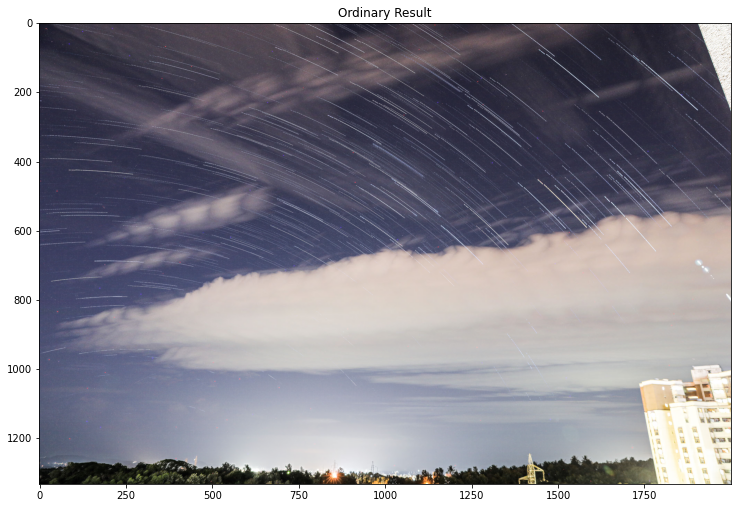

In [7]:

"""
Change the arguments in the function below :

- SAVE      : `bool`
- OVERWRITE : `bool`
"""

imgViewDt  = None

def blend_direct(save=False, overwrite=False):

    global imgViewDt
    
    imgStackDt = baseImg[SLICE[1]:SLICE[2], SLICE[0]:SLICE[3]]

    for ipath in SOURCE_PATH:
        img = cv2.imread(ipath)[SLICE[1]:SLICE[2], SLICE[0]:SLICE[3]]
        imgStackDt = cv2.max(img, imgStackDt)
        
        if save:
            if not os.path.isdir('./processed'):
                os.mkdir('./processed')
            p = './processed/d_'+os.path.split(ipath)[1]
            if os.path.isfile(p):
                if overwrite : os.remove(p)
                else : raise FileExistsError(f"{os.path.abspath(p)} cannot be replaced. You must enable the 'overwrite' option")
            cv2.imwrite(p, imgStackDt)
            print("saving", os.getcwd()+'/processed/'+os.path.split(ipath)[1])

    imgViewDt = displayimg(imgStackDt, "Ordinary Result", close=imgViewDt)
    return imgViewDt
    
blend_direct()


In [8]:
plt.show()